# Identifying CpG islands in long stretch of Human DNA

## Primary Authors:
- Go, Daphne Janelyn
- Gilo, Joshua
- Lasala, Kyle Carlo

## Objectives: 
1. Implement an HMM to identify CpG islands in a stretch of human genome sequence
2. Compare the obtained CpG islands against other functional annotations

In this notebook, we will focus only for ***chromosomes 18 (chr18) and 19 (chr19)***. To do this, we must download the transcript sequences of the [human from the Gencode website](https://www.gencodegenes.org/human/) in *fasta* format. Then, we will filter the transcript sequences to chr18 and chr19 only. 

Since we want to create an HMM to identify CpG islands, we must have some reference to build the HMM. In this case, chr18 will be the reference to build the HMM, and chr19 will be the test. We must then download the annotations which is available from this [website](https://genome.ucsc.edu/cgi-bin/hgTables).

Telomeres and centromeres are not included in CpG island annotation because they are composed of repetitive DNA sequences that often contain many CG dinucleotides, but these do not reflect the role of DNA methylation on CpG islands in promoter silencing [1]. CpG islands are commonly located near gene promoters and are important for regulating gene expression—whether a gene is turned on or off. This regulation is often linked to DNA methylation, where methyl groups are added to cytosines in CpG sites, potentially silencing a gene [2].

[1] Illingworth, R. S., & Bird, A. P. (2009). CpG islands - “A rough guide.” FEBS Letters, 583(11), 1713–1720. https://doi.org/10.1016/j.febslet.2009.04.012

[2]Takai, D., & Jones, P. A. (2002). Comprehensive analysis of CpG islands in human chromosomes 21 and 22. Proceedings of the National Academy of Sciences, 99(6), 3740–3745. https://doi.org/10.1073/pnas.052410099

## Prerequisites: Downloading the necessary data and importing the libraries.

#### 1. Transcript sequences of human
- Download the transcript sequences in fasta format through this [link](https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_48/gencode.v48.annotation.gtf.gz).
- Extract the compressed file.
- Save the `.fa` file in the same directory to this notebook.
#### 2. CpG annotations of chr18
- Visit this [link](https://genome.ucsc.edu/cgi-bin/hgTables?hgsid=2704278040_OaSFhQdDeBEVFapezdB5gB3xi4A8&clade=mammal&org=Human&db=hg38&hgta_group=regulation&hgta_track=knownGene&hgta_table=0&hgta_regionType=range&position=chr18%3A1-80%2C373%2C285&hgta_outputType=primaryTable&hgta_outFileName=chr18_cpg.csv) to download the CpG annotations for chr18.
- In the `Retrieve and display data` section, click `Get Output`.
- Create a folder in the same directory to this notebook and name it as `chr18`. This will be the folder to store all necessary annotations for chr18.
- Put the downloaded file to the created `chr18` folder.
- Rename the file to `cpg.csv`.
#### 3. CpG annotations of chr19
- Visit this [link](https://genome.ucsc.edu/cgi-bin/hgTables?hgsid=2704300444_QgqWfKbdKoFV0vuiiN7MuzCQzc7y&clade=mammal&org=Human&db=hg38&hgta_group=regulation&hgta_track=crossTissueMapsTissueCellType&hgta_table=0&hgta_regionType=range&position=chr19%3A1-58%2C617%2C616&hgta_outputType=primaryTable&hgta_outFileName=chr19_cpg.csv) to download the CpG annotations .for chr19.
- In the `Retrieve and display data` section, click `Get Output`
- Create a folder in the same directory to this notebook and name it as `chr19`. This will be the folder to store all necessary annotations for chr19.
- Put the downloaded file to the created `chr19` folder.
- Rename the file to `cpg.csv`.
#### 4. Telomeres annotations of chr18
- Visit this [link](https://genome.ucsc.edu/cgi-bin/hgTables?hgsid=2706253784_Nxuk8VF2q4Ow1XXIujef5nIApjB6&clade=mammal&org=Human&db=hg38&hgta_group=map&hgta_track=gap&hgta_table=0&hgta_regionType=range&position=chr18%3A1-80%2C373%2C285&hgta_outputType=wigData&hgta_outFileName=chr18_telo.csv).
- In the `Retrieve and display data` section, click `Get Output`.
- Put the downloaded file in the `chr18` folder. Note that we are getting the gaps annotation, not just the telomeres. This will be further processed in the provided code later on to get only the telomeres.
- Rename the file to `telomeres.csv`.
#### 5. Telomeres annotations of chr19
- Visit this [link](https://genome.ucsc.edu/cgi-bin/hgTables?hgsid=2706253784_Nxuk8VF2q4Ow1XXIujef5nIApjB6&clade=mammal&org=Human&db=hg38&hgta_group=map&hgta_track=gap&hgta_table=0&hgta_regionType=range&position=chr19&hgta_outputType=primaryTable&hgta_outFileName=chr19_telo.csv).
- In the `Retrieve and display data` section, click `Get Output`.
- Put the downloaded file in the `chr18` folder. Note that we are getting the gaps annotation, not just the telomeres. This will be further processed in the provided code later on to get only the telomeres.
- Rename the file to `telomeres.csv`.
#### 6. Centromeres annotations of chr18
- Visit this [link](https://genome.ucsc.edu/cgi-bin/hgTables?hgsid=2704300444_QgqWfKbdKoFV0vuiiN7MuzCQzc7y&clade=mammal&org=Human&db=hg38&hgta_group=map&hgta_track=centromeres&hgta_table=0&hgta_regionType=range&position=chr18%3A1-58%2C617%2C616&hgta_outputType=primaryTable&hgta_outFileName=chr18_centromeres.csv) to download the centromere annotations for chr18.
- In the `Retrieve and display data` section, click `Get Output`.
- Put the downloaded file in the `chr18` folder.
- Rename the file to `centromeres.csv`.
#### 7. Centromeres annotations of chr19 
- Visit this [link](https://genome.ucsc.edu/cgi-bin/hgTables?hgsid=2704300444_QgqWfKbdKoFV0vuiiN7MuzCQzc7y&clade=mammal&org=Human&db=hg38&hgta_group=map&hgta_track=centromeres&hgta_table=0&hgta_regionType=range&position=chr19%3A1-58%2C617%2C616&hgta_outputType=wigData&hgta_outFileName=chr19_centromeres.csv) to download the centromere annotations for chr19.
- In the `Retrieve and display data` section, click `Get Output`.
- Put the downloaded file in the `chr19` folder.
- Rename the file to `centromeres.csv`.
#### 8. Gene locations of chr19
- Visit this [link](https://genome.ucsc.edu/cgi-bin/hgTables?hgsid=2709118318_TvMkTJpaRqF0JQGkeJInx9movsdY&clade=mammal&org=Human&db=hg38&hgta_group=genes&hgta_track=knownGene&hgta_table=0&hgta_regionType=range&position=chr19%3A1-58%2C617%2C616&hgta_outputType=primaryTable&hgta_outFileName=gene_chr19.csv)
- In the `Retrieve and display data` section, click `Get Output`.
- Put the downloaded file in the root directory.

In [ ]:
!pip install biopython

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   -------------- ------------------------- 1.0/2.8 MB 8.5 MB/s eta 0:00:01
   -------------------------- ------------- 1.8/2.8 MB 3.5 MB/s eta 0:00:01
   ----------------------------- ---------- 2.1/2.8 MB 3.8 MB/s eta 0:00:01
   ---------------------------------------- 2.8/2.8 MB 3.2 MB/s eta 0:00:00


In [1]:
!pip install hmmlearn

Defaulting to user installation because normal site-packages is not writeable


In [5]:
import pandas as pd
import numpy as np
from Bio import SeqIO
from hmmlearn import hmm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import gffutils

### Read the data and check for overlapping regions

Function that helps read fasta files

In [2]:
def read_fasta(file_path, filter_header=None):
    sequences = ''
    for record in SeqIO.parse(file_path, "fasta"):
        if filter_header and filter_header not in record.id:
            continue
        sequences = record.seq
    return sequences

Function that helps read the annotation files

In [3]:
def read_centro_telo(file_path_centro, file_path_telo, file_path_cpg):
    centro = pd.read_csv(file_path_centro)
    centro.drop('#"bin"', axis=1, inplace=True)
    
    telo = pd.read_csv(file_path_telo)
    telo.drop('#bin', axis=1, inplace=True)
    telo = telo[telo['type'] == 'telomere']
    
    cpg = pd.read_csv(file_path_cpg)
    cpg.drop('#"bin"', axis=1, inplace=True)
    
    return centro, telo, cpg

Function that checks if there is an overlapping telomeres, centromeres, or CpG islands.

In [7]:
def check_overlap(centro, telo, cpg):
    telo.sort_values('chromStart', inplace=True)
    
    start_telo = telo[['chromStart', 'chromEnd']].iloc[0, 1]
    end_telo = telo[['chromStart', 'chromEnd']].iloc[1, 0]

    if len(cpg[cpg['chromStart'] < start_telo]) > 0 or len(cpg[cpg['chromEnd'] > end_telo]) > 0:
        print("There is a CpG island overlapping with Telomeric regions.")
    else:
        print("There is NO overlapping CpG island with Telomeric regions.")
        
    centro.sort_values('chromStart', inplace=True)
    min_centro = centro[['chromStart','chromEnd']].iloc[0,0]
    max_centro = centro[['chromStart','chromEnd']].iloc[len(centro)-1, 1]

    if len(cpg[(cpg['chromStart'] > min_centro) & (cpg['chromEnd'] < max_centro)]) > 0:
        print("Do a manual inspection because there is a CpG island in between the Centromeric regions.")
    else:
        print("There is NO overlapping CpG island with Centromeric regions.")

Reads the transcript sequences of chr18 and its corresponding annotations

In [4]:
seq = read_fasta('./GRCh38.p14.genome.fa', 'chr18')
centro18_df, telo18_df, cpg18_df = read_centro_telo('./chr18/centromeres.csv','./chr18/telomeres.csv', './chr18/cpg.csv')

Checks for overlapping regions

In [10]:
check_overlap(centro18_df, telo18_df, cpg18_df)

There is NO overlapping CpG island with Telomeric regions.
There is NO overlapping CpG island with Centromeric regions.


### Construct the transition probabilities of HMM using chr18

Function that checks if the current state is in the given region

In [12]:
def check_in_start_end(i, index, start_end, in_):
    if index < len(start_end):
        if not in_ and i >= start_end[index]:
            return True, index + 1
        if in_ and i >= start_end[index]:
            return False, index + 1
    return in_, index    

Linearly traverse the sequence and count each states and transitions

There are several ways to calculate the transition and initial probabilities of $X=\{A_{-}, G_{-}, C_{-}, T_{-}, A_{+}, G_{+}, C_{+}, T_{+}\}$.

1. **Initial Probabilities**:
   - Uniform probability distribution. $$p(x)=\frac{1}{n}$$ where  $n=|X|$. In this case, $n=8$ and $p=\frac{1}{8}.$
   - Stationary probability distribution [1]. $$v=Av$$ where $v$ is the probability distribution of $X$, $A=[a_{ij}]$ is the transition probabilities, and $v_i=p(x_i)$.
   - Empirical probability distribution. $$p(x)=\frac{\text{freq}(x)}{\Sigma_{x'\in X}\ \text{freq}(x')}$$ where $\text{freq}(x)$ is the count of state $x$ in the given data.
2. **Transition Probabilities**:
   - Maximum Likelihood Estimation (MLE) [2]. Maximize the likelihood of the observed sequence
   - Empirical probability. $$a_{kl}=P(\pi_i=k|\pi_{i-1}=l)=\frac{\text{freq}(l\rightarrow k)}{\Sigma_{x\in X}\ \text{freq}(l\rightarrow x)}$$ where $A=[a_{kl}]$, $\pi$ is the given sequence, and $\text{freq}(x\rightarrow y)$ is the frequency of $x$ transitioning to $y$ given that $x,y\in X$.

There are other ways that are not discussed. ***However, in this notebook, the probabilities are empirical based.***

[1] M. Seah, “Markov Chains and Hidden Markov Models,” Undergraduate REU, University of Chicago Mathematics Department, Dec. 5, 2017. [Online]. Available: https://math.uchicago.edu/~may/REU2017/REUPapers/Seah.pdf

[2] B. G. Leroux, “Maximum-likelihood estimation for hidden Markov models,” Stochastic Processes and their Applications, vol. 40, no. 1, pp. 127–143, Feb. 1992.

In [13]:
# check regions for ith base
in_cpg = False
cpg_index = 0

in_centro = False
centro_index = 0

in_telo = False
telo_index = 0

# check regions for (i+1)th base
in_cpg_next = False
cpg_index_next = 0

in_centro_next = False
centro_index_next = 0

in_telo_next = False
telo_index_next = 0

# flatten the regions
telo_start_end = telo18_df.sort_values('chromStart')[['chromStart', 'chromEnd']].to_numpy().flatten()
centro_start_end = centro18_df.sort_values('chromStart')[['chromStart', 'chromEnd']].to_numpy().flatten()
cpg_start_end = cpg18_df.sort_values('chromStart')[['chromStart', 'chromEnd']].to_numpy().flatten()

# Format: A-, G-, C-, T-, A+, G+, C+, T+
init = np.zeros(8) # data structure for initial probabilities
tran = np.zeros((8,8)) # data structure for transition probabilities

# base to index
state_index = {
    'A-': 0,
    'G-': 1,
    'C-': 2,
    'T-': 3,
    'A+': 4,
    'G+': 5,
    'C+': 6,
    'T+': 7,
}

# linearly traverse the sequence
for i in range(len(seq)):
    # check if in telomeric region
    in_telo, telo_index = check_in_start_end(i, telo_index, telo_start_end, in_telo)
    if in_telo:
        continue

    # check if in centromeric region
    in_centro, centro_index = check_in_start_end(i, centro_index, centro_start_end, in_centro)
    if in_centro:
        continue

    # check if in CpG island
    in_cpg, cpg_index = check_in_start_end(i, cpg_index, cpg_start_end, in_cpg)

    # avoid ambiguous bases N
    if seq[i] == 'N':
        continue

    # counting the frequency of each Markov States
    base_i = seq[i] + ('+' if in_cpg else '-')
    init[state_index[base_i]] += 1

    if i + 1 < len(seq):
        # check if next index in telomeric region
        in_telo_next, telo_index_next = check_in_start_end(i + 1, telo_index_next, telo_start_end, in_telo_next)
        if in_telo_next:
            continue

        # check if next base in centromeric region
        in_centro_next, centro_index_next = check_in_start_end(i + 1, centro_index_next, centro_start_end, in_centro_next)
        if in_centro_next:
            continue

        # check if next base in CpG island
        in_cpg_next, cpg_index_next = check_in_start_end(i + 1, cpg_index_next, cpg_start_end, in_cpg_next)

        # avoid ambiguous bases N
        if seq[i+1] == 'N':
            continue

        base_i_next = seq[i + 1] + ('+' if in_cpg_next else '-')
        tran[state_index[base_i_next], state_index[base_i]] += 1

Construct the initial probabilities

In [16]:
init_probs = init/init.sum()
init_probs

array([0.29997011, 0.19703748, 0.19670899, 0.30027983, 0.00093958,
       0.00205016, 0.00206689, 0.00094697])

Construct the transition probabilities

In [17]:
tran_probs = tran/tran.sum(axis=1)[:, np.newaxis]
tran_probs

array([[3.36673990e-01, 1.95908309e-01, 2.39228107e-01, 2.28186162e-01,
        0.00000000e+00, 3.43276126e-06, 0.00000000e+00, 0.00000000e+00],
       [3.47248782e-01, 2.44139710e-01, 4.30627657e-02, 3.65536322e-01,
        0.00000000e+00, 1.24203267e-05, 0.00000000e+00, 0.00000000e+00],
       [2.54927379e-01, 2.02469356e-01, 2.44062515e-01, 2.98531777e-01,
        0.00000000e+00, 8.97388884e-06, 0.00000000e+00, 0.00000000e+00],
       [2.67780742e-01, 1.67633343e-01, 2.27956537e-01, 3.36624168e-01,
        0.00000000e+00, 5.21063363e-06, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.99077698e-01, 3.56594885e-01, 3.58744075e-01, 8.55833416e-02],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.89002316e-01, 3.56557190e-01, 2.92117022e-01, 1.62323473e-01],
       [6.34074381e-04, 8.41119077e-04, 1.30696964e-03, 5.11141593e-04,
        1.24278579e-01, 3.47272186e-01, 3.57223272e-01, 1.

Sanity check

In [18]:
# sanity check for initial probabilities
print("Total should be 1")
print(init_probs.sum())
# sanity check for transition probabilities
print("All elements must total to 1")
print(tran_probs.sum(axis=1))

Total should be 1
1.0
All elements must total to 1
[1. 1. 1. 1. 1. 1. 1. 1.]


Check Transition Probabilities

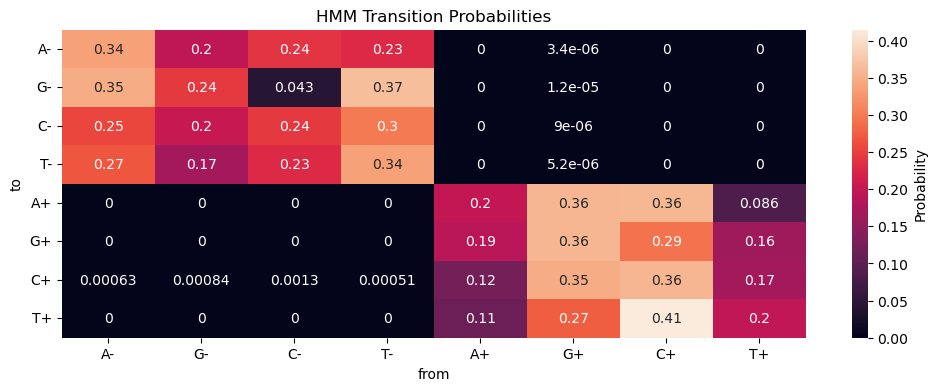

In [3]:
plt.figure(figsize=(12,4))
sns.heatmap(tran_probs, annot=True, cbar_kws={'label': 'Probability'})
plt.xticks(ticks=np.arange(8)+0.5, labels=[each for each in state_index.keys()])
plt.xlabel("from")
plt.ylabel("to")
plt.yticks(ticks=np.arange(8)+0.5, labels=[each for each in state_index.keys()], rotation=0)
plt.title("HMM Transition Probabilities")
plt.show()

Check Initial Probabilities

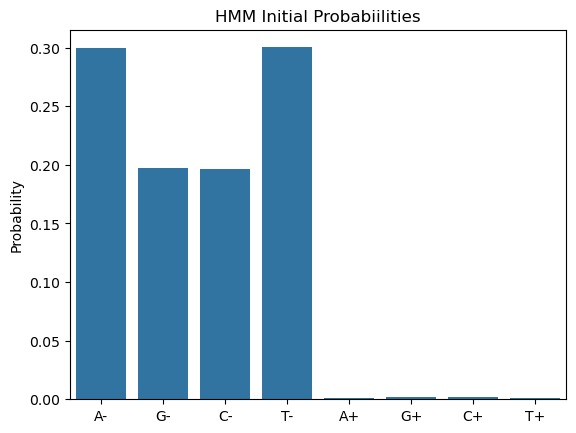

In [20]:
sns.barplot(init_probs)
plt.xticks(ticks=np.arange(8), labels=[each for each in state_index.keys()])
plt.ylabel("Probability")
plt.title("HMM Initial Probabiilities")
plt.show()

Checkpoint

In [20]:
# Checkpoint for transition probabilities
np.savetxt("transition_probs.csv", tran_probs, delimiter=",")
# Checkpoint for initial probabilities
np.savetxt("initial_probs.csv", init_probs, delimiter=",")

### Extract regions of chr19 WITHOUT telomere and centromere

Function that checks if the current state is in the given region

In [61]:
def check_in_start_end(i, index, start_end, in_):
    if index < len(start_end):
        if not in_ and i >= start_end[index]:
            return True, index + 1
        if in_ and i >= start_end[index]:
            return False, index + 1
    return in_, index    

Function that searches for first index without ambiguous base N

In [62]:
def find_first_valid_index(seq):
    for i, base in enumerate(seq):
        if base != 'N':
            return i
    return -1

Function that searches for first index with N

In [63]:
def find_first_invalid_index(seq):
    for i, base in enumerate(seq):
        if base == 'N':
            return i
    return -1

Function that finds a subsequence such that
- end of first telomere region- start of first centromere region
- skip all centromere regions 
- end of last centromere - start of second/last telomere region

A telomere is a region of repetitive DNA sequences at the end of a chromosome. Both chr18 and chr19 have only two telomere regions.

In [64]:
def find_valid_subsequence(seq):
    start_index = find_first_valid_index(seq)
    if start_index == -1:
        return 0, 0, ''

    end_index = find_first_invalid_index(seq[start_index:])
    if end_index == -1:
        return start_index, len(seq), seq[start_index:]

    end_index += start_index
    return start_index, end_index, seq[start_index:end_index]

Reads the transcript sequences of chr19 and its corresponding annotations

In [65]:
seq_test = read_fasta('./GRCh38.p14.genome.fa', 'chr19')
centro19_df, telo19_df, cpg19_df = read_centro_telo('./chr19/centromeres.csv','./chr19/telomeres.csv', './chr19/cpg.csv')

Check for overlapping regions

In [66]:
check_overlap(centro19_df, telo19_df, cpg19_df)

There is NO overlapping CpG island with Telomeric regions.
There is NO overlapping CpG island with Centromeric regions.


Extract 2 subsequences from chr19 

In [67]:
# Extract start of the first centromere and end of last centromere
start_centro = centro19_df['chromStart'][0]
end_centro = centro19_df['chromEnd'].iloc[-1]

# Extract end of the first telomere and start of the last telomere
end_first_telo = telo19_df['chromEnd'].iloc[0]
start_last_telo = telo19_df['chromStart'].iloc[-1]

# Extract 2 subsequences 
seq_test_1 = seq_test[end_first_telo: start_centro] # end of first telomere until start of first centromere
seq_test_2 = seq_test[end_centro: start_last_telo]  # end of last centromere until start of last telomere

Checkpoint

In [68]:
start_index_1, end_index_1, valid_subsequence_1 = find_valid_subsequence(seq_test_1)
start_index_2, end_index_2, valid_subsequence_2 = find_valid_subsequence(seq_test_2)

with open('seq_test_1_withoutN.fasta', 'w') as f:
    f.write(f'>seq_test_1_withoutN\tindex {end_first_telo + start_index_1}:{end_first_telo+ end_index_1}\n{valid_subsequence_1}\n')
with open('seq_test_2_withoutN.fasta', 'w') as f:
    f.write(f'>seq_test_2_withoutN\tindex {end_centro + start_index_2}:{end_centro+ end_index_2}\n{valid_subsequence_2}\n')

In [70]:
end_index_1 - start_index_1

24388980

### Build HMM

In [5]:
states = ['A-', 'G-', 'C-', 'T-', 'A+', 'G+', 'C+', 'T+']
n_states = len(states)

In [6]:
transition_probs = np.loadtxt("transition_probs.csv", delimiter=",")
initial_probs = np.loadtxt("initial_probs.csv", delimiter=",")
emit_probs = np.concatenate([np.eye(4), np.eye(4)])

In [7]:
model = hmm.CategoricalHMM(n_components=n_states, verbose=True)
model.startprob_= initial_probs
model.emissionprob_ = emit_probs
model.transmat_ = transition_probs

### Decode using the HMM

Function that converts letters into numbers and stores into a numpy array

In [8]:
def get_gene_sequence(filename):
    file = read_fasta(filename)
    gene = str(file)            
    out = []
    
    for char in gene :
        if char == "A":
            out.append([0])
        elif char == "G":
            out.append([1])
        elif char == "C":
            out.append([2])
        else:
            out.append([3])
            
    return np.array(out)

Reads the selected stretches of chr19

In [9]:
test_sequence_np_1 = get_gene_sequence("seq_test_1_withoutN.fasta")

In [10]:
test_sequence_np_2 = get_gene_sequence("seq_test_2_withoutN.fasta")

Decode using Viterbi Algorithm

In [77]:
logprob_1_vit, output_bases_1_vit = model.decode(test_sequence_np_1, algorithm="viterbi")
out_1_vit = "%s"%" ".join([states[x][-1] for x in output_bases_1_vit])

In [78]:
logprob_2_vit, output_bases_2_vit = model.decode(test_sequence_np_2, algorithm="viterbi")
out_2_vit = "%s"%" ".join([states[x][-1] for x in output_bases_2_vit])

Decode using Posterior Algorithm

Support for posterior estimation is denoted through the use of "map" based from the [HMMLearn documentation](https://hmmlearn.readthedocs.io/en/latest/tutorial.html#available-models) .

In [79]:
logprob_1_pos, output_bases_1_pos = model.decode(test_sequence_np_1, algorithm="map")
out_1_pos = "%s"%" ".join([states[x][-1] for x in output_bases_1_pos])

In [80]:
logprob_2_pos, output_bases_2_pos = model.decode(test_sequence_np_2, algorithm="map")
out_2_pos = "%s"%" ".join([states[x][-1] for x in output_bases_2_pos])

Checkpoint

In [81]:
# Viterbi outputs
with open ("output_1_vit.txt", "w") as f:
    f.write(out_1_vit)
with open ("output_2_vit.txt", "w") as f:
    f.write(out_2_vit)

In [82]:
# Posterior outputs
with open ("output_1_pos.txt", "w") as f:
    f.write(out_1_pos)

with open ("output_2_pos.txt", "w") as f:
    f.write(out_2_pos)

### HMM Evaluation

Read the CpG annotation of chr19

In [8]:
_, _, cpg19_df = read_centro_telo('./chr19/centromeres.csv','./chr19/telomeres.csv', './chr19/cpg.csv')
cpg_start_end = cpg19_df.sort_values('chromStart')[['chromStart', 'chromEnd']].to_numpy().flatten()

Extract start and end indices of the two test subsequences for chr19

In [9]:
def extract_header(filepath):
    seq = next (SeqIO.parse(filepath, "fasta"))
    header = seq.description
    index_field = header.split("\t")[1]
    range_index = index_field.split()[1]
    start_index = int(range_index.split(":")[0])
    end_index = int(range_index.split(":")[1])
    # remove seq from memory
    del seq
    return start_index, end_index

In [10]:
# read fasta using seqio
start_index_1, end_index_1 = extract_header("seq_test_1_withoutN.fasta")
print(f"Start index 1: {start_index_1}, End index 1: {end_index_1}")

start_index_2, end_index_2 = extract_header("seq_test_2_withoutN.fasta")
print(f"Start index 2: {start_index_2}, End index 2: {end_index_2}")

Start index 1: 60000, End index 1: 24448980
Start index 2: 27240874, End index 2: 58607616


Function that annotates the two subsequences as ground truth data (+ for CpG island and - for non-CpG island)

In [11]:
def get_ground_truth(start_index, end_index, cpg_start_end):
    ground_truth = np.full(end_index - start_index, '')
    starting_region = '-'

    # determine if the start index is in a non-CpG or CpG island
    for i, each in enumerate(cpg_start_end):
        if start_index < each:
            if i % 2:
                starting_region = '+'
            break
            
    # [starting_region, opposite]
    annot = [starting_region, '-' if starting_region == '+' else '+']
    
    # generate the ground truth
    curr_index = 0
    for j, k in enumerate(cpg_start_end[i:]):
        if j == 0:
            ground_truth[:each-start_index] = starting_region
            curr_index += each-start_index
        elif k > end_index:
            ground_truth[curr_index : curr_index + end_index - cpg_start_end[j-1]] = annot[j % 2]
            break
        else:
            ground_truth[curr_index : curr_index + k - cpg_start_end[j-1]] = annot[j % 2]            
            curr_index += k-cpg_start_end[j-1]
    return ground_truth, annot

Function that computes the performance metrics of HMM and displays it

In [12]:
def get_performance_metrics(confusion_mat):
    TN, FP = confusion_mat[0]
    FN, TP = confusion_mat[1]
    
    precision = TP / (TP + FP) if (TP + FP) != 0 else 0
    recall = TP / (TP + FN) if (TP + FN) != 0 else 0
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"Accuracy: {accuracy:.2f}")

In [13]:
ground_truth_1, annot_1 = get_ground_truth(start_index_1, end_index_1, cpg_start_end)
ground_truth_2, annot_2 = get_ground_truth(start_index_2, end_index_2, cpg_start_end)
ground_truth = np.concatenate((ground_truth_1, ground_truth_2))

#### Viterbi Algorithm

Read the outputs of HMM model to the selected stretches of chr19 using Viterbi

In [14]:
output_1_vit = np.loadtxt("output_1_vit.txt", delimiter=" ", dtype=str)
output_2_vit = np.loadtxt("output_2_vit.txt", delimiter=" ", dtype=str)
output_vit = np.concatenate((output_1_vit, output_2_vit))

Obtain and plot confusion matrices, one for each subsequence, and one combined.

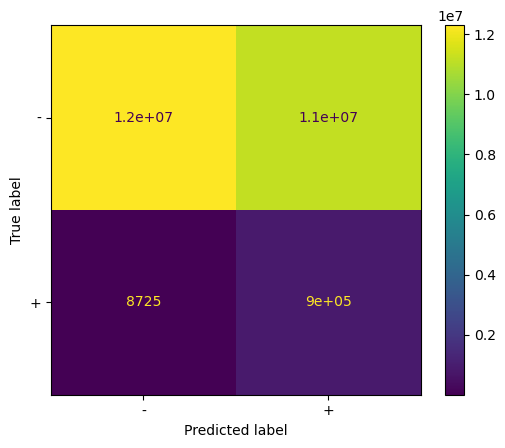

In [12]:
confusion_mat_1_vit = confusion_matrix(ground_truth_1, output_1_vit, labels=annot_1)
disp_1_vit = ConfusionMatrixDisplay(confusion_matrix=confusion_mat_1_vit, display_labels=annot_1)
disp_1_vit.plot()
plt.show()

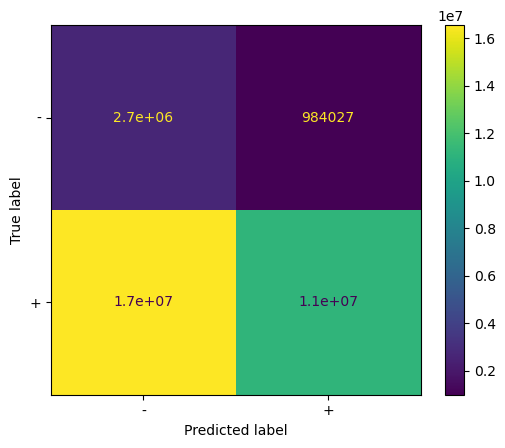

In [13]:
confusion_mat_2_vit = confusion_matrix(ground_truth_2, output_2_vit, labels=annot_2)
disp_2_vit = ConfusionMatrixDisplay(confusion_matrix=confusion_mat_2_vit, display_labels=annot_2)
disp_2_vit.plot()
plt.show()

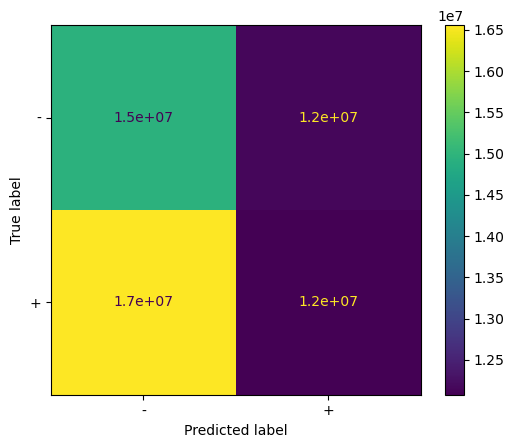

In [14]:
confusion_mat_vit = confusion_matrix(ground_truth, output_vit, labels=annot_1)
disp_vit = ConfusionMatrixDisplay(confusion_matrix=confusion_mat_vit, display_labels=annot_1)
disp_vit.plot()
plt.show()

In [15]:
print ("Performance Metrics for Viterbi Outputs:")
print ("Sequence 1:")
get_performance_metrics(confusion_mat_1_vit)
print ()
print ("Sequence 2:")
get_performance_metrics(confusion_mat_2_vit)
print ()
print ("Combined Performance Metrics:")
get_performance_metrics(confusion_mat_vit)

Performance Metrics for Viterbi Outputs:
Sequence 1:
Precision: 0.07
Recall: 0.99
Accuracy: 0.54

Sequence 2:
Precision: 0.92
Recall: 0.40
Accuracy: 0.44

Combined Performance Metrics:
Precision: 0.50
Recall: 0.42
Accuracy: 0.48


#### Posterior Algorithm

Read the outputs of HMM model to the selected stretches of chr19 using Posterior

In [15]:
output_1_pos = np.loadtxt("output_1_pos.txt", delimiter=" ", dtype=str)
output_2_pos = np.loadtxt("output_2_pos.txt", delimiter=" ", dtype=str)

Obtain and plot confusion matrices, one for each subsequence, and one combined.

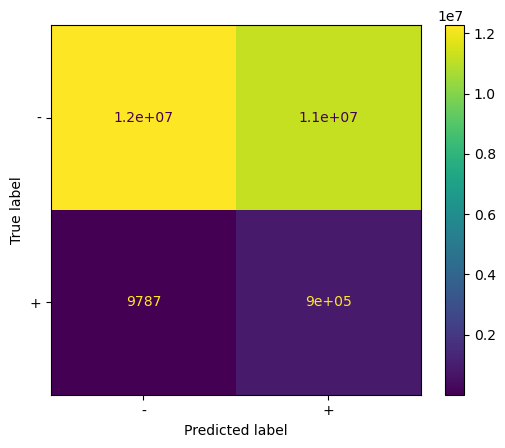

In [17]:
confusion_mat_1_pos = confusion_matrix(ground_truth_1, output_1_pos, labels=annot_1)
disp_1_pos = ConfusionMatrixDisplay(confusion_matrix=confusion_mat_1_pos, display_labels=annot_1)
disp_1_pos.plot()
plt.show()

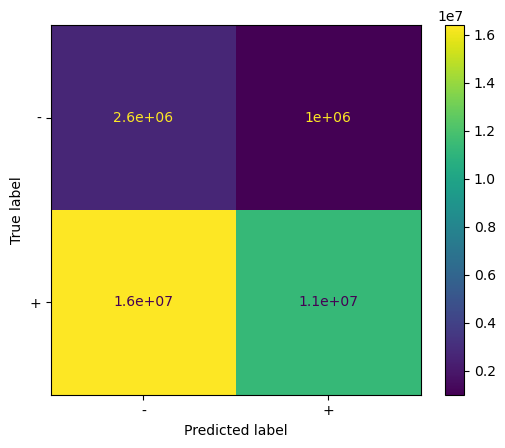

In [18]:
confusion_mat_2_pos = confusion_matrix(ground_truth_2, output_2_pos, labels=annot_2)
disp_2_pos = ConfusionMatrixDisplay(confusion_matrix=confusion_mat_2_pos, display_labels=annot_2)
disp_2_pos.plot()
plt.show()

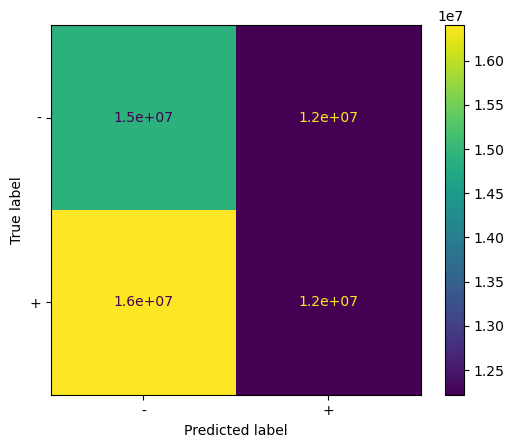

In [19]:
output_pos = np.concatenate((output_1_pos, output_2_pos))
confusion_mat_pos = confusion_matrix(ground_truth, output_pos, labels=annot_1)
disp_pos = ConfusionMatrixDisplay(confusion_matrix=confusion_mat_pos, display_labels=annot_1)
disp_pos.plot()
plt.show()

In [20]:
print ("Performance Metrics for Posterior Outputs:")
print ("Sequence 1:")
get_performance_metrics(confusion_mat_1_pos)
print()
print ("Sequence 2:")
get_performance_metrics(confusion_mat_2_pos)
print()
print ("Combined Performance Metrics:")
get_performance_metrics(confusion_mat_pos)

Performance Metrics for Posterior Outputs:
Sequence 1:
Precision: 0.07
Recall: 0.99
Accuracy: 0.54

Sequence 2:
Precision: 0.92
Recall: 0.41
Accuracy: 0.45

Combined Performance Metrics:
Precision: 0.50
Recall: 0.43
Accuracy: 0.49


#### Results and Discussion:

There is not much difference between Viterbi algorithm and Posterior decoding. This coincides with the results of [1] where the two decoding algorithms did not yield much difference. 

It is important to note however, that the two test sequences from chr19 used are quite long - which explains the large values seen in the confusion matrices. In both Viterbi and Posterior decoding results, there are a lot of false positives on predicted CpG islands. While the model successfully identifies many true CpG islands, the high false positive rate indicates that it struggles to clearly distinguish between CpG and non-CpG regions. 

Specifically, for sequence 1, the HMM is over-predicting the positive class, resulting in catching almost every real positive (high recall) but labeling many negatives as positives (low precision). This might suggest that the model is too liberal in tagging positives. In sequence 2, the HMM is conservative as it only predicts positive when it's very sure, leading to high precision but missing many true positives (low recall). Poor accuracy suggests the class imbalance or incorrect classification in general.


Similar results were observed by [1] using a set of 41 sequences each with a putative CpG island. The study reported that when using Viterbi, all except two CpG islands were predicted and 121 false positives. Whereas, when using Posterior decoding, the same two CpG islands were also missed with 236 false positives.

[1] R. Durbin, Biological sequence analysis : probabilistic models of proteins and nucleic acids. Cambridge Cambridge Univ. Press, 2010.

#### CpG Length Distributions

In [16]:
def compute_cpg_len(output):
    count = 0
    island_len = []
    in_cpg = False
    for each in output:
        if each == '+':
            count += 1
        elif count != 0:
            island_len.append(count)
            count = 0
    return np.array(island_len)

In [17]:
true_islands_len_1 = cpg19_df[(cpg19_df['chromStart'] > start_index_1) & (cpg19_df['chromEnd'] <= end_index_1)][['length']].to_numpy().flatten()
true_islands_len_2 = cpg19_df[(cpg19_df['chromStart'] > start_index_2) & (cpg19_df['chromEnd'] <= end_index_2)][['length']].to_numpy().flatten()
vit_islands_len_1 = compute_cpg_len(output_1_vit)
pos_islands_len_1 = compute_cpg_len(output_1_pos)
vit_islands_len_2 = compute_cpg_len(output_2_vit)
pos_islands_len_2 = compute_cpg_len(output_2_pos)

In [18]:
true_islands_len = np.concatenate((true_islands_len_1, true_islands_len_2))
vit_islands_len = np.concatenate((vit_islands_len_1, vit_islands_len_2))
pos_islands_len = np.concatenate((pos_islands_len_1, pos_islands_len_2))

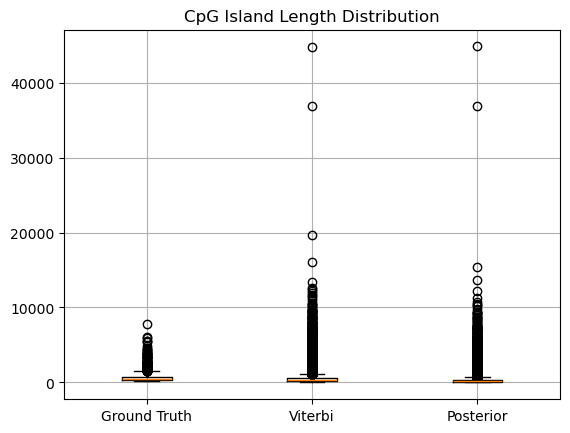

In [19]:
islands_lens = [true_islands_len, vit_islands_len, pos_islands_len]
plt.boxplot(islands_lens)
plt.title('CpG Island Length Distribution')
plt.xticks([1, 2, 3], ['Ground Truth', 'Viterbi', 'Posterior'])  # Labeling x-axis
plt.grid(True)
plt.show()

In [48]:
print(f"Ground Truth Max CpG Length: {max(true_islands_len)}")
print(f"Viterbi Max CpG Length: {max(vit_islands_len)}")
print(f"Posterior Max CpG Length: {max(pos_islands_len)}")

Ground Truth Max CpG Length: 7814
Viterbi Max CpG Length: 44801
Posterior Max CpG Length: 44805


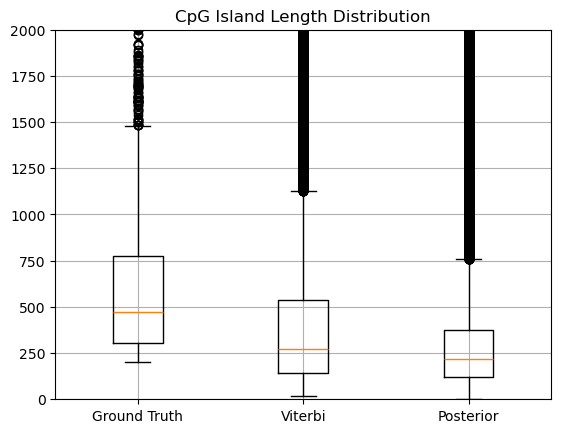

In [20]:
islands_lens = [true_islands_len, vit_islands_len, pos_islands_len]
plt.boxplot(islands_lens)
plt.title('CpG Island Length Distribution')
plt.xticks([1, 2, 3], ['Ground Truth', 'Viterbi', 'Posterior'])  # Labeling x-axis
plt.grid(True)
plt.ylim(0, 2000)
plt.show()

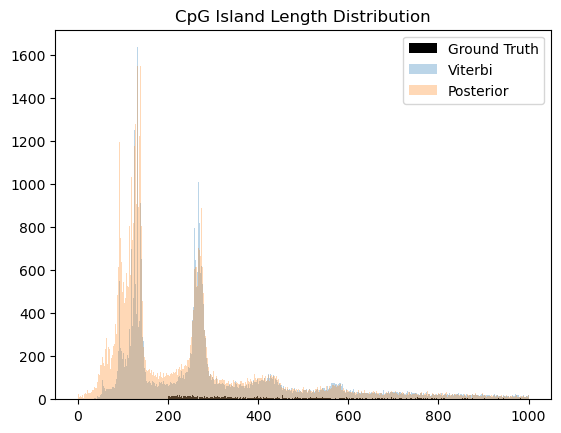

In [47]:
bins = numpy.linspace(0, 1_000, 500)
plt.hist(true_islands_len, bins, alpha=1, label='Ground Truth', color='black')
plt.hist(vit_islands_len, bins, alpha=0.3, label='Viterbi')
plt.hist(pos_islands_len, bins, alpha=0.3, label='Posterior')
plt.legend(loc='upper right')
plt.title('CpG Island Length Distribution')
plt.show()

#### Results and Discussion: 
As shown in the box plots for both sequence 1 and 2, there have been some outliers identified. We may attribute these outliers to the model struggling to clearly distinguish between CpG and non-CpG regions. The model may also be sensitive to sequence characteristics (e.g., sequence length).

From the distribution of predicted CpG Islands, it is quite consistent that the range of most predicted CpG islands are within 100-200 base pairs. However, as reported by [2], an average CpG Island is 1300bp, with CpG islands on small regions at the range of 200-400 base pairs. Most of the predicted islands for our model are very short, as shown in the spikes in the distribution of predicted CpG islands at 100-200 bp. This coincides with the observation of [1] regarding predicted CpG Islands by their HMM model. This is in contrast to the ground truth data with CpG islands that are within the range of 200-1000bp.


[1] R. Durbin, Biological sequence analysis : probabilistic models of proteins and nucleic acids. Cambridge Cambridge Univ. Press, 2010.

[2] D. Takai and P. A. Jones, “Comprehensive analysis of CpG islands in human chromosomes 21 and 22,” Proceedings of the National Academy of Sciences, vol. 99, no. 6, pp. 3740–3745, Mar. 2002, doi: https://doi.org/10.1073/pnas.052410099.

### Gene Annotation

Gene annotation for chr19 was derived. Using the annotated start coordinates, the promoter regions were obtained by obtaining regions ~1000bp upstream of genes 

In [ ]:
gencode_file = 'gencode.v48.annotation.gtf'
db_file = 'gencode.db'
gencode_db = gffutils.create_db(gencode_file, dbfn=db_file, disable_infer_genes=True, disable_infer_transcripts=True, force=True, keep_order=True, merge_strategy='merge', sort_attribute_values=True)

In [16]:
query = """
    SELECT * FROM features
    WHERE featuretype == "gene" AND seqid == "chr19";
"""
gencode_df = pd.read_sql(query, gencode.conn)

In [18]:
gencode_df = gencode_df[['seqid','start', 'end', 'strand']]
gencode_df = gencode_df.sort_values(by='start')

Based on the annotated strand (+: 5′ → 3′ and −: 3′ ← 5′), the upstream regions are defined as follows:

For genes on the + strand:

  Upstream = (start of gene - 1000) to start of gene

For genes on the − strand:

  Upstream = end of gene to (end of gene + 1000)

In [20]:
with open("chr19_promoter.bed", "w") as f:
    for i, row in gencode_df.iterrows():
        if row["strand"] == "+":
            start = row["start"] - 1000
            end = row["start"]
        else:
            start = row["end"]
            end = row["end"] + 1000
        f.write(f"chr19\t{start}\t{end}\n")

In [ ]:
with open("chr19_cpg.bed", "w") as f:
    for i, row in cpg19_df.sort_values('chromStart').iterrows():
        f.write(f"chr19\t{row["chromStart"]}\t{row["chromEnd"]}\n")

Fishers Test using BedTools

t.genome is defined as the length of chr19 which is 58,617,616.

In [ ]:
# sort the promoter regions
!bedtools sort -i chr19_promoter.bed > chr19_promoter_sorted.bed

In [ ]:
!bedtools fisher -a chr19_promoter_sorted.bed -b chr19_cpg.bed -g t.genome > stats_chr19.txt

Results
Note that a is for Promoter Regions, b is for CpG Islands.
- Number of query intervals: 3547
- Number of db intervals: 2492
- Number of overlaps: 1325
- Number of possible intervals (estimated): 35119
- phyper(1325 - 1, 3547, 35119 - 3547, 2492, lower.tail=F)

Contingency Table Of Counts
|               | in -b       | not in -b   |
|---------------|-------------|-------------|
| in -a         | 1325        | 2222        |
| not in -a     | 1167        | 30405       |


p-values for fisher's exact test
| Left | Right | Two-tail | Ratio   |
|------|-------|----------|---------|
| 1    | 0     | 0        | 15.536  |

With a p-value < 0.05 for right tail, we conclude that Promoter Regions overlap with Cpg Islands more than expected.